<a href="https://colab.research.google.com/github/mikful/audio-app-mf-ct/blob/master/nbs/fastai2_model_colab_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification model training - Freesound 2019 Kaggle Competition dataset

* Model - pretrained fastai2 xresnet50 using fastai2 audio library
* Dataset - Curated Train Set from Kaggle Freesound 2019 Competition, multi-label 80 classes


**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio


**For AWS setup look here and in fastai forum emails at Matt McClean email**
The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

In [ ]:
# See runtime gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug 10 21:40:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Google drive and Unzip data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -d '../content/train_curated' -qq  "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/train_curated.zip"

In [ ]:
!cp "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/train_curated.csv" '../content' 

In [ ]:
import os
files = os.listdir('../content/train_curated')
len(files)

4970

## COLAB ONLY - INSTALL FASTAI2

In [ ]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 4.4MB/s 


## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [ ]:
#In Colab we need to run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/rbracco/fastai2_audio.git -q

     |████████████████████████████████| 6.7MB 5.0MB/s 


In [ ]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

# !conda install -c conda-forge libsndfile --yes

# Train the fastai model
First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [ ]:
from fastai2.vision.all import *
from fastai2_audio.core.all import *
from fastai2_audio.augment.all import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [ ]:
# Create train_curated Dataframe

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

In [ ]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
df_curated = create_train_curated_df('../content/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [ ]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,6a8bb201.wav,Scissors
freq,1,75


Let's also unlink these corrupted files from the file structure;

In [ ]:
for corrupt_file in remove_files:
    corrupt = Path('train_curated', corrupt_file)
    print(corrupt.exists())
    print(corrupt)
    os.unlink(corrupt)

True
train_curated/f76181c4.wav
True
train_curated/77b925c2.wav
True
train_curated/6a1f682a.wav
True
train_curated/c7db12aa.wav
True
train_curated/7752cc8a.wav
True
train_curated/1d44b0bd.wav


**Now define the data paths**

First we're going to try to train with the curated train set only to see the performance. Then we can mix both the curated and noise train set to see the results.

In [ ]:
fnames = df_curated['fname']

In [ ]:
fnames[:5]

0    0006ae4e.wav
1    0019ef41.wav
2    001ec0ad.wav
3    0026c7cb.wav
4    0026f116.wav
Name: fname, dtype: object

In [ ]:
fdir = '../content/train_curated'
fpaths = [Path(fdir,df_curated['fname'][ind]) for ind in df_curated.index]

In [ ]:
len(fpaths)

4964

## Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [ ]:
def get_file(r): return '../content/train_curated/'+r['fname']
def get_label(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_file, get_y = get_label)
dsets = dblock.datasets(df_curated)
dsets.train[0]

('../content/train_curated/34ce2dee.wav', ['Gong'])

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [ ]:
clip_length = 2 # clip subsection length in seconds
sr = 44100 # sample rate
f_min = 20 # mel-spectrogram minimum frequency
f_max = 20000 # mel-spectrogram minimum frequency
n_mels = 128 # mel-frequency bins
hop_length = 256 # determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 20 # = 2560 for higher resolution in y-axis
win_length = 2048 # sample windowing
top_db = 90 # highest noise level in relative db

In [ ]:
hop_length

256

In [ ]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec = DBMelSpec(sample_rate=sr, win_length=win_length, 
                     f_max=f_max, f_min=f_min, n_mels=n_mels, 
                     n_fft=nfft, hop_length=hop_length, top_db=top_db)
aud2spec.settings

{'f_max': 20000,
 'f_min': 20,
 'hop_length': 256,
 'mel': True,
 'n_fft': 2560,
 'n_mels': 128,
 'normalized': False,
 'pad': 0,
 'power': 2.0,
 'sample_rate': 44100,
 'stype': 'power',
 'to_db': True,
 'top_db': 90,
 'win_length': 2048,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'wkwargs': None}

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [ ]:
item_tfms = [RemoveSilence(threshold=20), 
             CropSignal(clip_length*1000), 
             aud2spec, 
             MaskTime(num_masks=1, size=8), MaskFreq(num_masks=1, size=8)]

Now let's build our `DataBlock` 

**note: `get_x` not working on model export and `load_learner`, so commented and using version below with the labeller function**

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

**Note - using lambda functions here as going to export the learner!!**

In [ ]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.1, seed=42), # ensure reproducibility with seed
                    get_x=lambda r:'../content/train_curated/'+r['fname'],
                    get_y=lambda r:['labels'].split(','),
                    item_tfms = item_tfms)

dsets = dblock.datasets(df_curated)
dsets.train[0]

(AudioTensor([[ 2.1362e-04,  3.0518e-04,  1.4648e-03,  ...,  0.0000e+00,
          -3.0518e-05,  0.0000e+00]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

**Note: using this alternative DataBlock to remove `get_x` problem in unpickling of learn.export().**

Need to make our labeller function and test it:

In [ ]:
# def label_func(filep):
#     label = df_curated.loc[df_curated.fname == filep.name, 'labels'].values[0]
#     return label.split(',') # split labels on ','

In [ ]:
# fname = get_audio_files(fdir)
# fname

In [ ]:
# df_curated.head()

In [ ]:
# test_path = Path('../content/train_curated/001ec0ad.wav')

In [ ]:
# label_func(test_path)

In [ ]:
# # alternative datablock to solve pickling `get_x` problem

# fdir = Path('../content/train_curated')

# dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
#                     splitter=RandomSplitter(valid_pct=0.1, seed=42), # ensure reproducibility with seed
#                     get_items=get_audio_files,
#                     get_y=label_func,
#                     item_tfms = item_tfms)

# dsets = dblock.datasets(fdir)
# dsets.train[0]

In [ ]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 71180]), torch.Size([80]), 4468)

In [ ]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 347203]), torch.Size([80]), 496)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['Marimba_and_xylophone']

**Now we define our DataLoader**

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [ ]:
dls = dblock.dataloaders(df_curated, bs=64)

In [ ]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([64, 1, 128, 126])

Let's look at some augmented data:

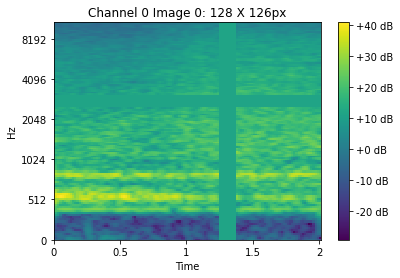

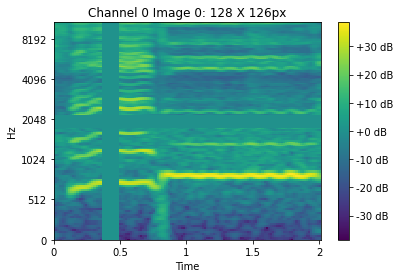

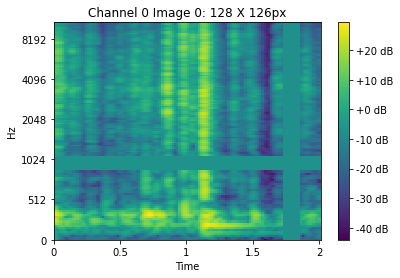

Mechanical_fan
Female_singing
Computer_keyboard


In [ ]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner. In addition, the learner will need the Binary Cross Entropy Loss, so we will need to combine both the approach from the fastai multicat notebook:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the fastai2 audio learner creation.

This will need the following steps:



1.   Create a standard CNN Learner
2.   Get the activation sizes from a single mini-batch
3. Pass the activation sizes to the BCELoss Function
4. Pass the BCE Loss function to the `audiolearner` function, which augments the Leaner to accept a single channel input




**Note on Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

say the fastai docs - double check.

Also, we change the output to be 80 neurons to match the label amount.


## Train our AudioLearner

Below are different options for learners - for experimentation

**see below and use threshold of 0.4 as investigated**

In [ ]:
### OPTION 1 - Pretrained 1-channel xresnet50 with multi-accuracy

# Custom cnn model created from pretrained xresnet18 (smaller model for inference speed)
# 1 input channel and 80 output nodes
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label

model = create_cnn_model(xresnet18, n_in=1, n_out=80, pretrained=False)

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=accuracy_multi) # pass custom model to Learner

In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 128 x 126'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 64 x 63    288        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 63    64         True      
________________________________________________________________
ReLU                 64 x 32 x 64 x 63    0          False     
________________________________________________________________
Conv2d               64 x 32 x 64 x 63    9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 63    64         True      
________________________________________________________________
ReLU                 64 x 32 x 64 x 63    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 63    18,432     True      
_________________________________________________

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.033113110810518265)

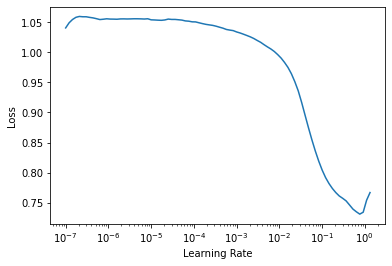

In [ ]:
# find the learning rate
learn.lr_find()

In [ ]:
# fit with one_cyle learning rate policy
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.321652,0.138487,0.983316,01:42
1,0.130973,0.072559,0.985610,01:40
2,0.086006,0.068453,0.985081,01:38
3,0.067767,0.056262,0.985585,01:39
4,0.059176,0.052542,0.985988,01:42


### Pick our threshold

**We can find the best threshold by picking a few threshold levels and seeing what works best in terms of our metric**

This is easy to do if we grab the predictions just once:

In [ ]:
preds,targs = learn.get_preds()

We can now use a list comprehension approach to test a range of threshold levels using these predictions:

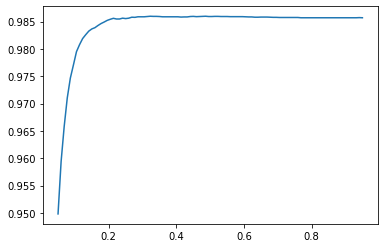

In [ ]:
xs = torch.linspace(0.05,0.95,100)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.0521828830242157,0.9779486060142517]

We can find where the maximum accuracy is acheived:

In [ ]:
np.max(accs)

0.9859879

In [ ]:
max_acc = np.argmax(accs) # get index of max
max_acc, xs[max_acc] # find threshold (xs) level of max

(30, tensor(0.3227))

So lets use a threshold of 0.3 in our metric and train from scratch:

In [ ]:
learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.3)) # pass custom model to Learner

In [ ]:
# fit with one_cyle learning rate policy
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.061395,0.182939,0.972354,01:40
1,0.063191,0.062300,0.984148,01:39
2,0.058171,0.050298,0.985181,01:40
3,0.052555,0.045661,0.986467,01:41
4,0.047428,0.042182,0.987223,01:41


In [ ]:
# Save the stage 1 model to allow quick fine tuning experimentation
learn.save('xresnet18-stage-1-model-frozen')

Now let's unfreeze the base model and train on the whole network:

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=2.2908675418875646e-06)

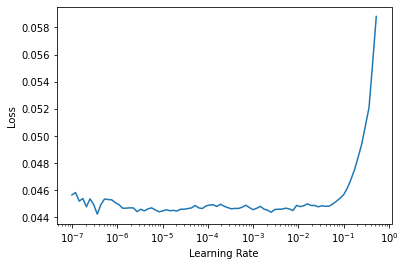

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.044785,0.041942,0.986769,01:41
1,0.044219,0.041207,0.987324,01:40
2,0.043561,0.040205,0.987576,01:39
3,0.043323,0.040145,0.987626,01:40
4,0.042852,0.040583,0.987802,01:38


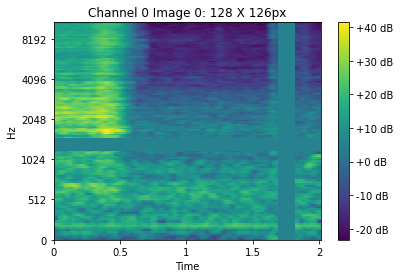

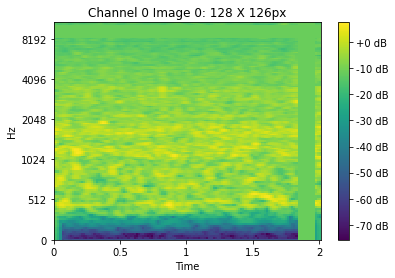

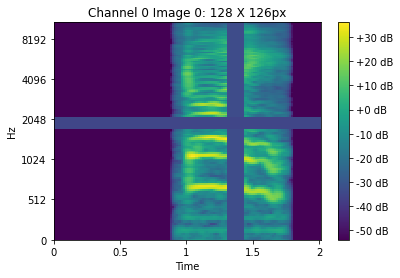

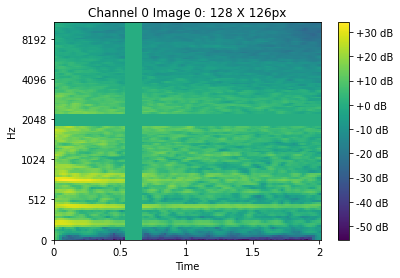

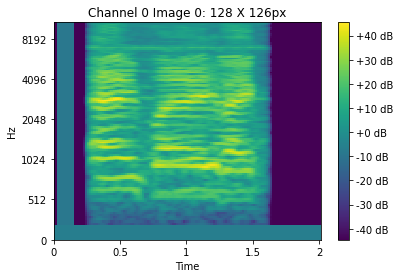

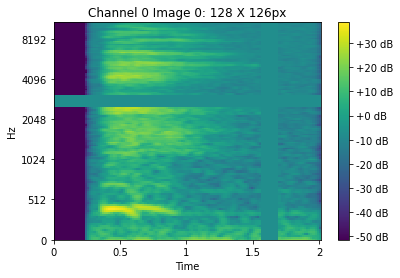

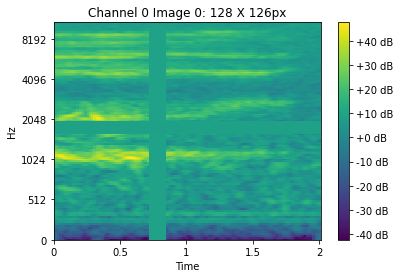

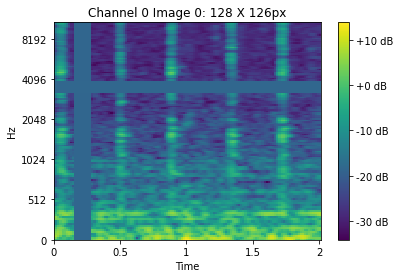

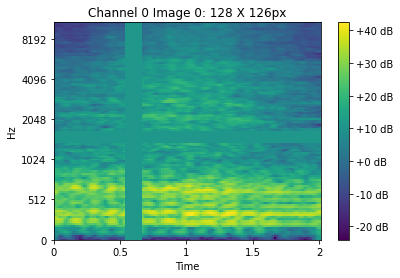

Toilet_flush
Stream
Child_speech_and_kid_speaking
Car_passing_by
Male_singing
Sigh
Hiss
Tick-tock
Motorcycle


Child_speech_and_kid_speaking








In [ ]:
learn.show_results()

In [ ]:
# Save the stage 2 model
path = '/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresnet18-stage-2-model-finetuned-v2'
learn.save(file=path, with_opt=True)

## Confusion Matrix / Data Cleaning

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Need Audio Cleaner option (check), equivalent to: 

# cleaner = ImageClassifierCleaner(learn)
# cleaner


In [ ]:
# # unlink cleaned files
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export and Test Model

In [ ]:
# Export Model
learn.export(fname='/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/resnet18-export-v2.pkl')

In [ ]:
# to get around AttributeError: Can't get attribute 'get_file' on <module '__main__'>

def get_file(r): return '../content/train_curated/'+r['fname']
def get_label(r): return r['labels'].split(',') # split labels on ','

In [ ]:
# # load learner for testing
learn = load_learner(fname='/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/resnet18-export-v2.pkl')

In [ ]:
# change metric

learn.metrics=partial(accuracy_multi, thresh=0.1)

In [ ]:
# see vocab
learn.dls.vocab

(#80) ['Accelerating_and_revving_and_vroom','Accordion','Acoustic_guitar','Applause','Bark','Bass_drum','Bass_guitar','Bathtub_(filling_or_washing)','Bicycle_bell','Burping_and_eructation'...]

In [ ]:
list(learn.dls.vocab)

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

## Inference testing

Now let's test the inference, taken from here: https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=xuKJ4wBU6gxx

In [ ]:
!pip install ffmpeg-python

In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

In [ ]:
from IPython.display import Audio
Audio('recording.wav')

There seems to be a problem with the prediction thresholds - the prediction is not given, despite being above the threshold as below - we can solve this below the next cell:

In [ ]:
# predict
# test_file = Path('recording.wav')
learn.predict('recording.wav')

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([4.0562e-03, 1.6097e-03, 3.5922e-03, 3.7896e-04, 8.6545e-03, 4.4233e-03,
         1.4141e-02, 3.8820e-04, 3.7031e-04, 1.0805e-02, 2.2020e-03, 3.5578e-03,
         2.2228e-04, 3.0849e-04, 3.2999e-04, 4.2612e-02, 1.4590e-03, 1.8644e-03,
         1.6664e-03, 1.1343e-03, 9.7969e-04, 6.7337e-06, 2.4055e-04, 7.1475e-04,
         3.9398e-03, 1.7141e-04,

In [ ]:
# try an
_,_,preds =  learn.predict('recording.wav')

In [ ]:
learn.dls.vocab[np.argwhere(preds > 0.3).squeeze()]

'Male_speech_and_man_speaking'

Try on training set:

In [ ]:
random_file = str("/content/train_curated/" + random.choice(os.listdir("/content/train_curated")))
random_file

'/content/train_curated/0afe72a0.wav'

In [ ]:
Audio(random_file)

In [ ]:
prediction, pred_idx, preds = learn.predict(random_file)

In [ ]:
np.argwhere(preds > 0.3).squeeze()

tensor(40)

In [ ]:
learn.dls.vocab[np.argwhere(preds > 0.3).squeeze()]

'Harmonica'

List dependencies for render.com requirements.txt:

In [ ]:
# check all dependencies for deployment requirements.txt on Render.com

!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
argon2-cffi              20.1.0         
asgiref                  3.2.10         
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.2.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    2.1.1          
boto                     2.49.0         
boto3                    1.14.33        
botocore        